In [179]:
import numpy as np
import importlib
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import networkx as nx

import loaddata
importlib.reload(loaddata)
from loaddata import load_data

import data_vis
importlib.reload(data_vis)
from data_vis import mat2graph, plot_graph

import spectral_clustering_tools
importlib.reload(spectral_clustering_tools)
from spectral_clustering_tools import clustering, df2mat

import graph_analysis_tools
importlib.reload(graph_analysis_tools)
from graph_analysis_tools import group_interactions, add_queen

import test_tools
importlib.reload(test_tools)
from test_tools import trainset, testset, crossvalidation

import markov_roles
importlib.reload(markov_roles)
from markov_roles import markov_chain

## DATASET 2


In [150]:
metadata, data = load_data('dataset2')

###    Spectral clustering

In [151]:
matrices, ground_truth, list_ants = df2mat(np.arange(1,6), np.arange(1,41), metadata, data)

scores, preds = clustering(matrices, ground_truth, list_ants, scoring='acc')
print(np.mean(scores))


0.6794283633739592


### Random walk

In [14]:
matrices, ground_truth, list_ants = df2mat(np.arange(1,6), np.arange(1,41), metadata, data)
graph = mat2graph(matrices[0], 'dataset2_col1_d1', plot=False)
dict_clustering = nx.current_flow_betweenness_centrality_subset(graph, graph.nodes, graph.nodes, normalized=True)
print(dict_clustering)

{0: 0.023098353552123953, 1: 0.023342170548893273, 2: 0.017018421393671268, 3: 0.018476779739616277, 4: 0.01470560091911984, 5: 0.014382313448374094, 6: 0.016240672172490693, 7: 0.014404691994838752, 8: 0.019640677583407935, 9: 0.01627799472096253, 10: 0.014953345163813506, 11: 0.01822677711666637, 12: 0.01697958260242778, 13: 0.021029372702695157, 14: 0.01643064020983221, 15: 0.015888139586253902, 16: 0.013467925408169408, 17: 0.01833622965872548, 18: 0.019618456851250132, 19: 0.025457857109629112, 20: 0.021283405793956274, 21: 0.022806283028820422, 22: 0.016977463528397158, 23: 0.013227295678066823, 24: 0.022651949925343244, 25: 0.02776595727094796, 26: 0.01621615672478583, 27: 0.014036771928547664, 28: 0.009820210339739377, 29: 0.014017536868466534, 30: 0.01562862362625852, 31: 0.019362149353180813, 32: 0.01737518133232497, 33: 0.014300233278240952, 34: 0.017256535082846636, 35: 0.013458044472779042, 36: 0.020775921401025597, 37: 0.016359727895606885, 38: 0.01593016622009063, 39: 0.

In [18]:
# def betweenness_centrality2clusters(dict_betweenness, ants, eps):
#     init = np.mean()
#     res = {0:[], 1:[], 2:[]}
#     res_ants = {0: [], 1:[], 2:[]}
#     for n, bc in dict_betweenness.items():
#         if np.abs(np.mean(res[0]) - bc) <= eps:
#             res[0].append(bc)
#             res_ants[0].append(ants[n])
#         elif np.abs(np.mean(res[1]) - bc) <= eps:
#             res[1].append(bc)
#             res_ants[1].append(ants[n])
#         else:
#             res[2].append(bc)
#             res_ants[2].append(ants[n])
#     return res_ants

In [19]:
# eps = ( max(dict_clustering.values()) - min(dict_clustering.values()) )/3
# clustering_ants = betweenness_centrality2clusters(dict_clustering, list_ants[0], eps)

C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  ###  Group interactions analysis

In [152]:
col = 1
day = 1

####        Avec les labels de metadata (vérité terrain)

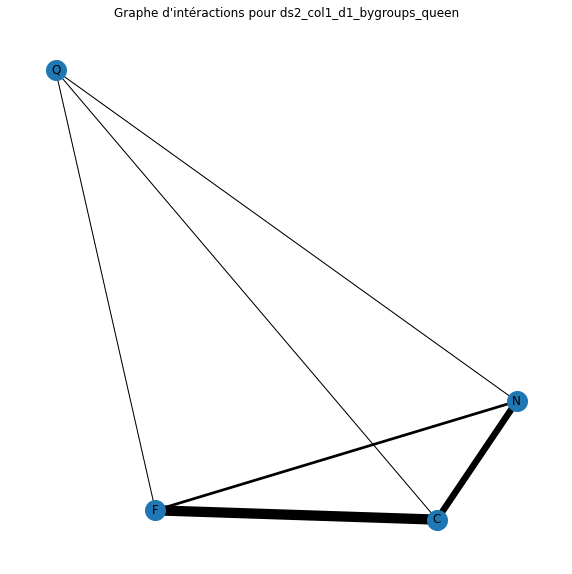

In [169]:
mat, y_true, ants = df2mat([col], [day], metadata, data, queen=True)
graph = mat2graph(mat[0], 'dataset2_col1_d1', plot=False)
graph_gr = group_interactions(graph, y_true[0], ants[0])
plot_graph(graph_gr, f'ds2_col{col}_d{day}_bygroups_queen')


#### Avec les labels prédits

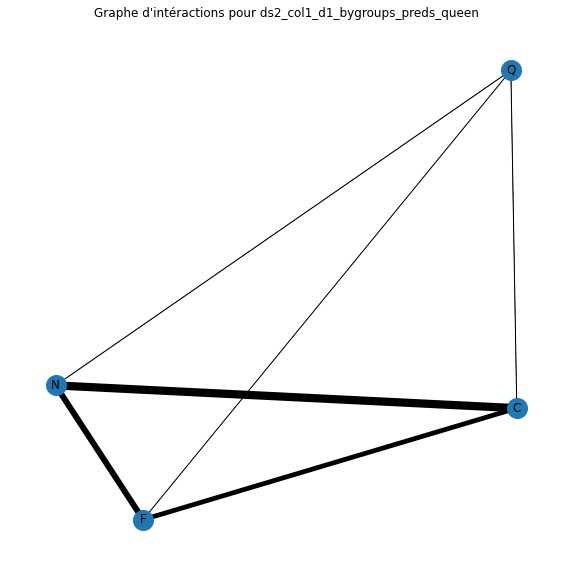

In [170]:
mat, y_true, ants = df2mat([col], [day], metadata, data, queen=False)
mat_queen, pred_queen, ants_queen = add_queen(mat[0], preds[0], ants[0], metadata, col, day, data[col-1][day-1])
if len(mat_queen) != 0:
    graph_pred_queen = mat2graph(mat_queen, f'dataset2_col{col}_d{day}', plot=False)
    graph_gr_pred = group_interactions(graph_pred_queen, pred_queen, ants_queen)
    plot_graph(graph_gr_pred, f'ds2_col{col}_d{day}_bygroups_preds_queen')

## Classification supervisée

In [163]:
period = 1

In [24]:
datax_train, datay_train = trainset(1, 1, metadata)
datax_test, datay_test = testset(1, 1, metadata)

In [106]:
supervised_classif_scores = pd.DataFrame(columns=['Classifieur', 'Accuracy train', 'Accuracy test', 'Precision train', 'Precision test', 'Recall train', 'Recall test'])

#### K-nearest neighbors

##### Recherche des meilleurs hyper paramètres

In [86]:
knn_clf = KNeighborsClassifier()
knn_param = {'n_neighbors' : np.arange(2, 15), 'weights' : ['uniform', 'distance']}
grid_search_knn = GridSearchCV(knn_clf, knn_param)
grid_search_knn.fit(datax_train, datay_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'weights': ['uniform', 'distance']})

In [28]:
print(grid_search_knn.best_params_)

{'n_neighbors': 10, 'weights': 'uniform'}


##### Classification avec validation croisée

In [107]:
knn_clf = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], weights=grid_search_knn.best_params_['weights'])
acc_test_knn, precision_test_knn, recall_test_knn = crossvalidation(knn_clf, metadata)
acc_train_knn, precision_train_knn, recall_train_knn  = crossvalidation(knn_clf, metadata, val='train')

In [108]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['knn', np.mean(acc_train_knn), np.mean(acc_test_knn),
                                                                       np.mean(precision_train_knn), np.mean(precision_test_knn),
                                                                       np.mean(recall_train_knn), np.mean(recall_test_knn)]

#### Decision Tree

##### Recherche des meilleurs hyper paramètres

In [33]:
dc_clf = DecisionTreeClassifier()
dc_param = {'criterion' : ['gini', 'entropy' ], 'max_depth' : np.arange(2,20)}
grid_search_dc = GridSearchCV(dc_clf, dc_param)
grid_search_dc.fit(datax_train, datay_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])})

In [34]:
print(grid_search_dc.best_params_)

{'criterion': 'gini', 'max_depth': 3}


##### Classification avec validation croisée

In [89]:
dc_clf = DecisionTreeClassifier(criterion=grid_search_dc.best_params_['criterion'], max_depth=grid_search_dc.best_params_['max_depth'])
acc_test_dc, precision_test_dc, recall_test_dc = crossvalidation(dc_clf, metadata)
acc_train_dc, precision_train_dc, recall_train_dc  = crossvalidation(dc_clf, metadata, val='train')

In [109]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['decision tree', np.mean(acc_train_dc), np.mean(acc_test_dc),
                                                                       np.mean(precision_train_dc), np.mean(precision_test_dc),
                                                                       np.mean(recall_train_dc), np.mean(recall_test_dc)]

#### Naive Bayes

##### Recherche des meilleurs hyper paramètres

In [53]:
nb_clf = ComplementNB()
nb_param = {'alpha' : [ 1e-10, 1e-8, 1e-5, 1e-2], 'norm' : ['False', 'True']}
grid_search_nb = GridSearchCV(nb_clf, nb_param)
grid_search_nb.fit(datax_train, datay_train)

GridSearchCV(estimator=ComplementNB(),
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.01],
                         'norm': ['False', 'True']})

In [54]:
print(grid_search_nb.best_params_)

{'alpha': 1e-10, 'norm': 'False'}


##### Classification avec validation croisée

In [92]:
nb_clf = ComplementNB(alpha=grid_search_nb.best_params_['alpha'], norm=grid_search_nb.best_params_['norm'])
acc_test_nb, precision_test_nb, recall_test_nb = crossvalidation(nb_clf, metadata)
acc_train_nb, precision_train_nb, recall_train_nb  = crossvalidation(nb_clf, metadata, val='train')

In [110]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['naive bayes', np.mean(acc_train_nb), np.mean(acc_test_nb),
                                                                       np.mean(precision_train_nb), np.mean(precision_test_nb),
                                                                       np.mean(recall_train_nb), np.mean(recall_test_nb)]

### SVM

##### Recherche des meilleurs hyper paramètres

In [64]:
svm_clf = LinearSVC(max_iter=5000)
svm_param = { 'C' : np.arange(0.05, 1.0, step=0.05), 'loss' : ['hinge', 'squared_hinge'], 'dual' : [True, False]}
grid_search_svm = GridSearchCV(svm_clf, svm_param)
grid_search_svm.fit(datax_train, datay_train)

C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

GridSearchCV(estimator=LinearSVC(max_iter=5000),
             param_grid={'C': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'dual': [True, False],
                         'loss': ['hinge', 'squared_hinge']})

In [65]:
print(grid_search_svm.best_params_)

{'C': 0.05, 'dual': True, 'loss': 'squared_hinge'}


##### Classification avec validation croisée

In [95]:
svm_clf = LinearSVC(max_iter=5000, C=grid_search_svm.best_params_['C'], dual=grid_search_svm.best_params_['dual'], loss=grid_search_svm.best_params_['loss'])
acc_test_svm, precision_test_svm, recall_test_svm = crossvalidation(svm_clf, metadata)
acc_train_svm, precision_train_svm, recall_train_svm  = crossvalidation(svm_clf, metadata, val='train')

C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Candice\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

In [111]:
supervised_classif_scores.loc[len(supervised_classif_scores.index)] = ['svm', np.mean(acc_train_svm), np.mean(acc_test_svm),
                                                                       np.mean(precision_train_svm), np.mean(precision_test_svm),
                                                                       np.mean(recall_train_svm), np.mean(recall_test_svm)]

### Etude des changements de rôles (Chaine de Markov)

In [164]:
roles = []
for colony in range(1,7):
    roles.append(markov_chain(metadata, colony))
for mat in roles: print(mat)


[[0.95098039 0.04901961 0.         0.        ]
 [0.38461538 0.52307692 0.09230769 0.        ]
 [0.01754386 0.22807018 0.75438596 0.        ]
 [0.         0.         0.         1.        ]]
[[0.78571429 0.21428571 0.         0.        ]
 [0.1971831  0.76056338 0.04225352 0.        ]
 [0.         0.14705882 0.85294118 0.        ]
 [0.         0.         0.         1.        ]]
[[0.9375     0.0625     0.         0.        ]
 [0.36923077 0.50769231 0.12307692 0.        ]
 [0.01986755 0.07284768 0.90728477 0.        ]
 [0.         0.         0.         1.        ]]
[[0.61290323 0.29032258 0.09677419 0.        ]
 [0.48484848 0.3030303  0.21212121 0.        ]
 [0.02272727 0.06818182 0.90909091 0.        ]
 [0.         0.         0.         1.        ]]
[[0.92207792 0.07792208 0.         0.        ]
 [0.54166667 0.41666667 0.04166667 0.        ]
 [0.0620155  0.17829457 0.75968992 0.        ]
 [0.         0.         0.         1.        ]]
[[0.90756303 0.09243697 0.         0.        ]
 [0.775 

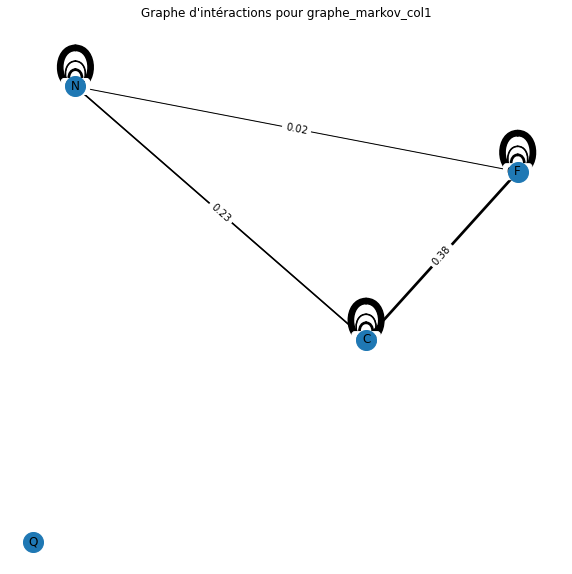

In [180]:
graphe_markov = mat2graph(roles[0], 'graphe_markov_col1', plot=False)
plot_graph(graphe_markov, 'graphe_markov_col1', show=True, self_loop=True, edge_labels=True)

In [166]:
print(graphe_markov)

Graph with 4 nodes and 6 edges


## TODO :
   ~~- fonction taux de similarité entre deux groupes pour évaluer le modèle~~
   ~~- interaction entre groupes (agréger les graphes -> 3 ou 4 noeuds (reine ou pas))~~
    ~~- chaîne de markov avec changements de rôles (prédire le comportement d'une fourmi)~~
    - mutual information pour évaluer le clustering et les comparer -> revoir
    - faire ressortir des indices pour évaluer l'intéraction (inter et intra groupes : pourcentage du nb d'interactions avec chaque groupe, nb moyen d'interactions par fourmi d'un groupe, variance associée, stabilité des interactions au cours du temps)
    ~~- mener une campagne d'expérience pour tous les modèles~~
 ~~-  classification supervisée (avec attributs de metadata)~~
    - additionner toutes les matrices de comptage du nombre d'intéractions d'une période et comparer les résultats
    - analyser les caractéristiques qui engendrent les changements de rôles (naive bayes)
    - clusteriser avec une marche aléatoire dans les graphes (pas le temps)